In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'iris:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F19%2F420%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240411%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240411T141421Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dce44f13ab4850057959023ffdb0fe797c1a7cce538ce7cd9c8abef899f56403de5e7a912c3622c8e42ca0b87d1225fa5b73a7bc8582d29372a5a440ae8fe9bcdfee3f44a5f3166a6dbfbcda83fe5cc18eb2247608b996e863ce0bd75ecae209888edbcbdaa97a9ac1320eaf618cfaad82f7ba76baac4efc3a44ea47adeb2ddee8424b7408cedc7575c9ea8449a8bf1c1c1dcedccf9b07aa06af8369d2b306b5166823c4d0ade31767b1409a131b82544399dc15fd3edbace1e081730472423724e805584ec2bede15857ec9d863cc0e367f66655fb903055ab823e464a761be0087bfbd6f12f8da5f88ee40591cc73e52c44add1f30b3bd6e1fe7803744e5680,migration-nz:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1367%2F2462%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240411%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240411T141421Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7bae26c746aade4211a47084a866abe3b7c8028a338117a3ce85a52cdf30bc599a943a6ed5a6f9fd474f472ec27c32ce75e674d5394395c42fe2301ee78df3caa9c137f67294a46de8e51ce45459468cee31cd74c1b167f2b818d2a1acfd0b8cf896918156aefc5ee1b11af7c9df6dcca124ee2f56caa4ac409caa6700cda9cb5f099cde71ff5109756d3a04d2bd4a9be5cdd43452600b4f776e90fac0b153b617445ed84eb1e85316c03ef5549b64867a2eeb261fc739fdcb5c8f2f95300966f0618b893847519d8ff126991d3ad6bd8a5431aff7710fdc5d57f87c2f3702534598d17a700e7d19b0266d7cd46d431b1b141dcd6bcf1338754d3c60168d70c3,annual-aquatic-and-terrestrial-monitoring-result:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F733338%2F1272488%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240411%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240411T141421Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0cb472fe18dd6e5d57f4b6378592630685c3d8f453b213b9633f8eca1f6b3b9f1063acc360384bc710d126f4f09921fa3362bf5a6729cda3ab8f00183ed298e6a7fab0a43f545e342ab79175e1bc487c0430d515e4cba192da35ba61c74d742fb2525541e8e30c5769617f1e3d3dc1b06879ad4ea9da729a7e4b740cf92fbfd9104b0698384361542079fd995a343bd16d0e2f1c1fd1b64e7ec3161ebfff6146d97841f4d26f7431e952950ee318f7ea6de9d0d9332573af50568078f16e3dfdc63e5aebc5cd41ae64bf3e6614e359bd34a210b4368c73359078b8bd5869b862fd1e556699abba1b03526d5ab86717601f263454a4d1002a634754a3a910079e,biological-invasions:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1166074%2F1959891%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240411%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240411T141421Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3De7dae0e06d4e7df18799213a21a16dc6871234e2125af07ed21f03847408aa6bfaafe346d83e39213bc4ed9e61b97a3c448d04d9a00b43d57efd1267a1531158b92a28a8b36bba148fe855c5419b800c6128446aa803cd5f26e605bbd084ef0c46c897f9433ae8b9a4fa93237cf6052b06597be63b65b3ef56cf534028a50471baf9b4f901b04ad806d79df2264ad3693214f0040be4ff257d8403afdb768902e60ab2c0d96ae8d2e62806d10588c82c6154b539d13e3ca4384323a2a1ec76e4e18b68a880b1734517b93ddb1e6c446652787ae21771db3767f33d17beb995fa49be458dca22a7efb98f9bd7f63709d30af23278b7b997df80bcb0d26d009396,covid-world-vaccination-progress:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1093816%2F1964023%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240411%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240411T141421Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Ddf14787a3bb836cd98b839d6f6082ba9485fb17b7dd340079fdcc08b7acb9bb78902491f7092b312c0db194c592f624b028c0d26eb7524f7705c8fea7557e14ebd8f251fbea305a8cf4354035bd87efa14d322614d39b4e8b0706b565a44a69d5ba390b5e3f853cade9f57c517fe8187c7db404fa34ea6d99512a76a03f3ce0550a6899dc07f3ae2715a0a63e191ab55f8ef437e8cab5729fd7ac199733cd2bd8299b56206b8621117c6035f6bc4bcea7fdb7be21fa2f0142b2acd99d2d71a5165b9ac77da510b10d0802a06a55cc3c2e19087c5914df2777d5cfcbae581bd128435f10f6b90066d395a03f39594f415d7b92e81b3bb30159cc682551f648ab6'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3687 bytes downloaded
Downloaded and uncompressed: iris
[==================================================] 489745 bytes downloaded
Downloaded and uncompressed: migration-nz
[==================================================] 195963 bytes downloaded
Downloaded and uncompressed: annual-aquatic-and-terrestrial-monitoring-result
[==================================================] 7783998 bytes downloaded
Downloaded and uncompressed: biological-invasions
[==================================================] 83481 bytes downloaded
Downloaded and uncompressed: covid-world-vaccination-progress
Data source import complete.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

#Spatial libaries
import geopandas as gpd
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

In [ ]:
#Get the data
spat=pd.read_csv('../input/biological-invasions/dat_spatial.csv')
spec=pd.read_csv('../input/biological-invasions/dat_species.csv')

<Axes: >

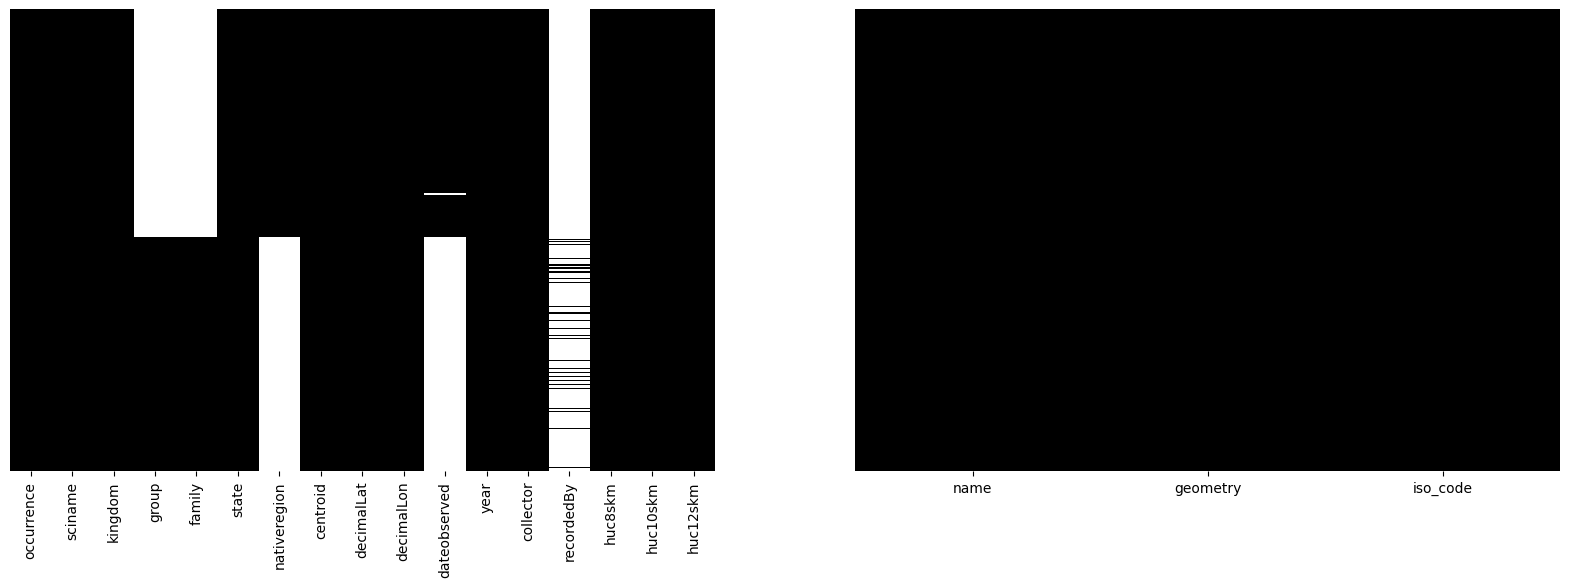

In [ ]:
#null values
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
sns.heatmap(spec.isna(),cmap='cubehelix',yticklabels=False,cbar=False,ax=ax[0])
sns.heatmap(spat.isna(),cmap='cubehelix',yticklabels=False,cbar=False,ax=ax[1])

In [ ]:
#Remove and fix null values
del spec['recordedBy']

array([[<Axes: title={'center': 'decimalLat'}>,
        <Axes: title={'center': 'decimalLon'}>],
       [<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'huc8skm'}>],
       [<Axes: title={'center': 'huc10skm'}>,
        <Axes: title={'center': 'huc12skm'}>]], dtype=object)

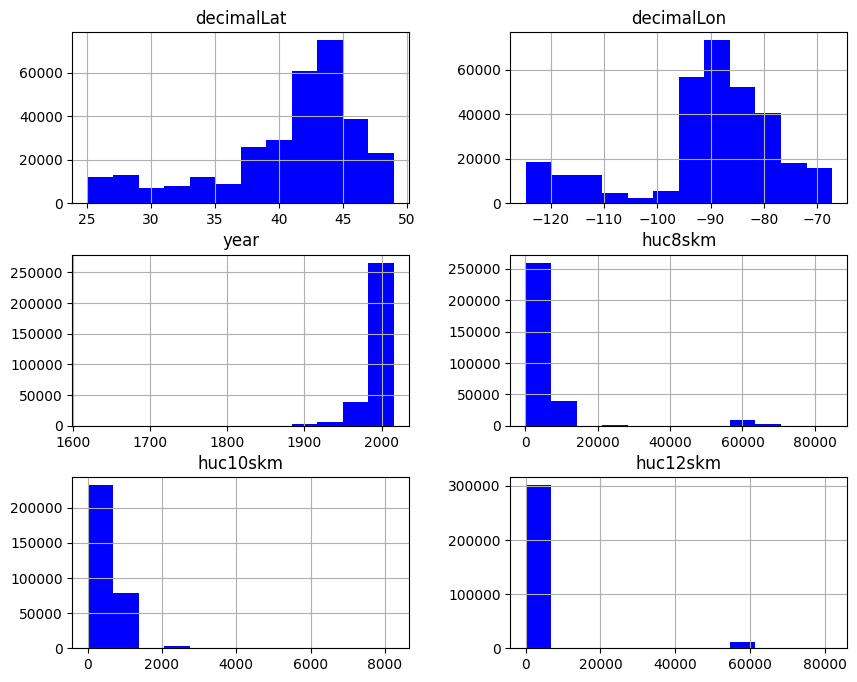

In [ ]:
#Analyze numeric features
spec['occurrence']=spec['occurrence'].astype('string')
spec.select_dtypes(include=['float64','int64']).hist(color='blue',figsize=(10,8),bins=12)

nativeregion
possibly native    280413
no native           33583
Name: count, dtype: int64


([<matplotlib.patches.Wedge at 0x7d3ae20f0190>,
 [Text(-1.0384874669857251, 0.36268964820294, 'possibly native'),
  Text(1.038487433028265, -0.3626897454331523, 'no native')],
 [Text(-0.47203975772078416, 0.16485893100133633, '89.3%'),
  Text(0.472039742285575, -0.1648589751968874, '10.7%')])

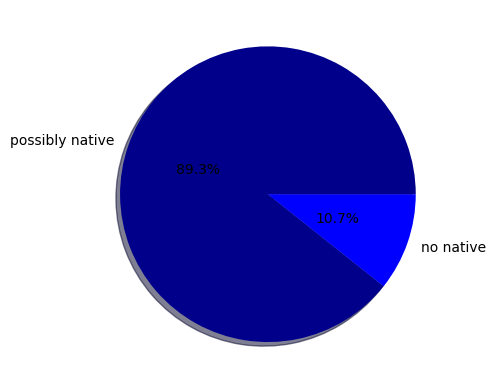

In [ ]:
#Analize 'text' features
spec.nativeregion.value_counts() #When I see this variable, I consider to define two values: possibly native or possibly foreign
def native_or_forecast(x):
    if str(x).find("possibly native")==-1: return('possibly native')
    else: return('no native')
print(spec.nativeregion.apply(native_or_forecast).value_counts())
plt.pie(spec.nativeregion.apply(native_or_forecast).value_counts(), autopct="%.1f%%",pctdistance=0.5,shadow=True,colors=['darkblue','blue'],labels=['possibly native','no native'])

Only claims that 10.7% is foreign.

What's the animal group more common ?
group
Fishes               125942
Amphibians-Frogs       9304
Mollusks               8910
Mollusks-Bivalves      7196
Name: count, dtype: int64


<Axes: xlabel='count', ylabel='family'>

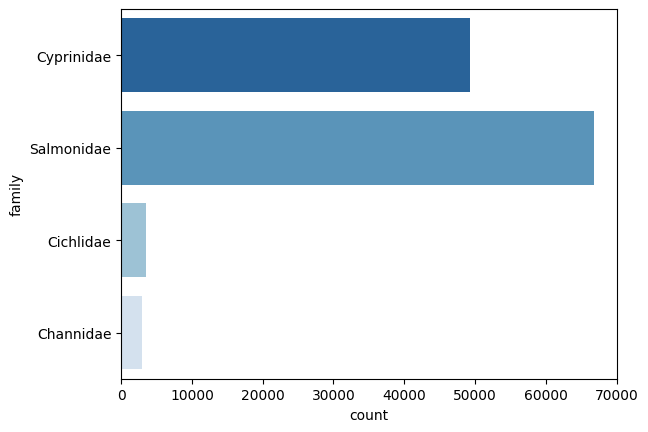

In [ ]:
#Analyze categorical features
animal=spec[spec.kingdom=='Animal']
#sns.countplot(animal.group)

print("What's the animal group more common ?")
print(animal.group.value_counts()[:4]) #Obviously, the fishes
animal=animal[animal.group=='Fishes']
#What's the fisshes family more common ?
an=animal.family.value_counts()[:4].keys()
sns.countplot(animal[animal['family'].isin(an)].family, palette="Blues_r")

Temporal features

In [ ]:
def gyear(x): #Cut the date
    if x<=1900: return('1600-1900')
    elif x<=1930: return('1901-1930')
    elif x<=1950: return('1931-1950')
    elif x<=1970: return('1951-1970')
    elif x<=1990: return('1971-1990')
    else: return('1991-2016')
spec['gyear']=spec['year'].apply(gyear)

In [ ]:
print('Arrival of species from 1600 to 2016')
print(spec.gyear.value_counts())
print('Which species came first?')
print(spec[spec.year<1800].sciname.value_counts().keys()) #
spec=spec[spec.gyear!='1600-1900'] #Remove that values

Arrival of species from 1600 to 2016
gyear
1991-2016    248558
1971-1990     43206
1951-1970     12284
1931-1950      5711
1901-1930      3053
Name: count, dtype: int64
Which species came first?
Index([], dtype='object', name='sciname')


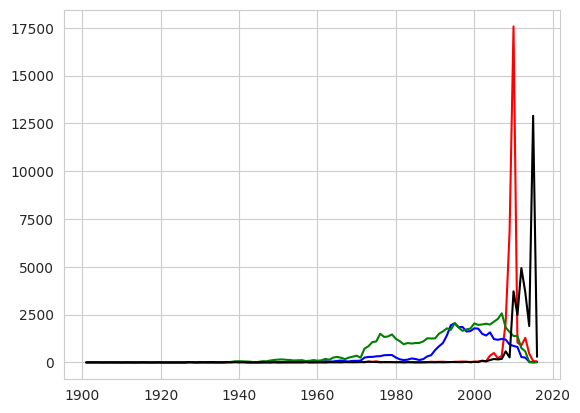

In [ ]:
import seaborn as sns
from collections import Counter

sns.set_style("whitegrid")

def temporal_trend(text, col):
    specie = spec[(spec.sciname == text)]
    temporal = Counter(specie.year)
    sns.lineplot(x=list(temporal.keys()), y=list(temporal.values()), color=col)

temporal_trend('Phalaris arundinacea', 'red')
temporal_trend('Cyprinus carpio', 'blue')
temporal_trend('Salmo trutta', 'green')
temporal_trend('Phragmites australis', 'black')


<Axes: >

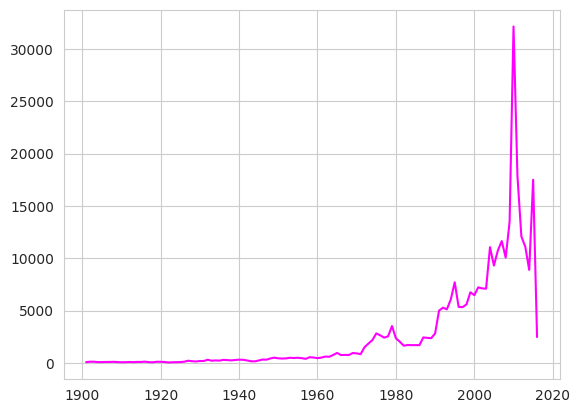

In [ ]:

# Calculate the occurrence of each species per year
temporal = Counter(spec.year)

# Plot the temporal trend of occurrence for all species
sns.lineplot(x=list(temporal.keys()), y=list(temporal.values()), sort=True, color='magenta')


In [ ]:
#I think that I should show them how to process the date features. Previously, in the original dataset, the format was distinct between the items

def preprocess_date(x): #Varies depending on the species chosen. Should return same datetime format
    if len(str(x))<11:return pd.to_datetime(x, format='%m-%d-%Y')
    else: return pd.to_datetime(str(x)[:10], format='%Y-%m-%d')

In [ ]:
import pandas as pd

# Convert 'dateobserved' to datetime, handling inconsistent formats
spec['date'] = pd.to_datetime(spec['dateobserved'], errors='coerce')

# Check for invalid datetime values
invalid_dates = spec[spec['date'].isnull()]
if not invalid_dates.empty:
    print("Invalid date values:")
    print(invalid_dates[['dateobserved', 'date']])

# Drop rows with invalid datetime values
spec.dropna(subset=['date'], inplace=True)

# Select only one species
specie = spec[spec.sciname == 'Phalaris arundinacea']


Invalid date values:
       dateobserved date
20              NaN  NaT
2436          16247  NaT
2437          16247  NaT
2438          16247  NaT
2439          16247  NaT
...             ...  ...
313991          NaN  NaT
313992          NaN  NaT
313993          NaN  NaT
313994          NaN  NaT
313995          NaN  NaT

[159766 rows x 2 columns]


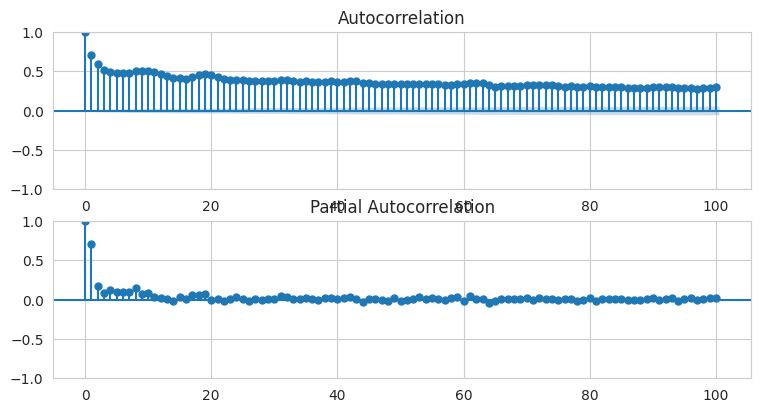

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(9, 4.5))

plot_acf(specie['date'], lags=100, ax=ax[0]) #Heavy decay
plot_pacf(specie['date'], lags=100, ax=ax[1])

plt.show()

In [ ]:
# Geopandas DataFrame. Deal with space features
from shapely import wkt
spat['geometry'] = spat['geometry'].apply(wkt.loads)
spat = gpd.GeoDataFrame(spat, geometry = 'geometry')

In [ ]:
#At any given time
spec_2015=spec[spec.year==2015] #Just this year
points=spec_2015[['decimalLat', 'decimalLon']]
points = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points.decimalLon, points.decimalLat)) #Elements to add
#ax = spat.plot(figsize=(20,20), color='none', edgecolor='black', zorder=1) #boundary
#points.plot(color='blue', ax=ax) This graph is confused..

<Axes: >

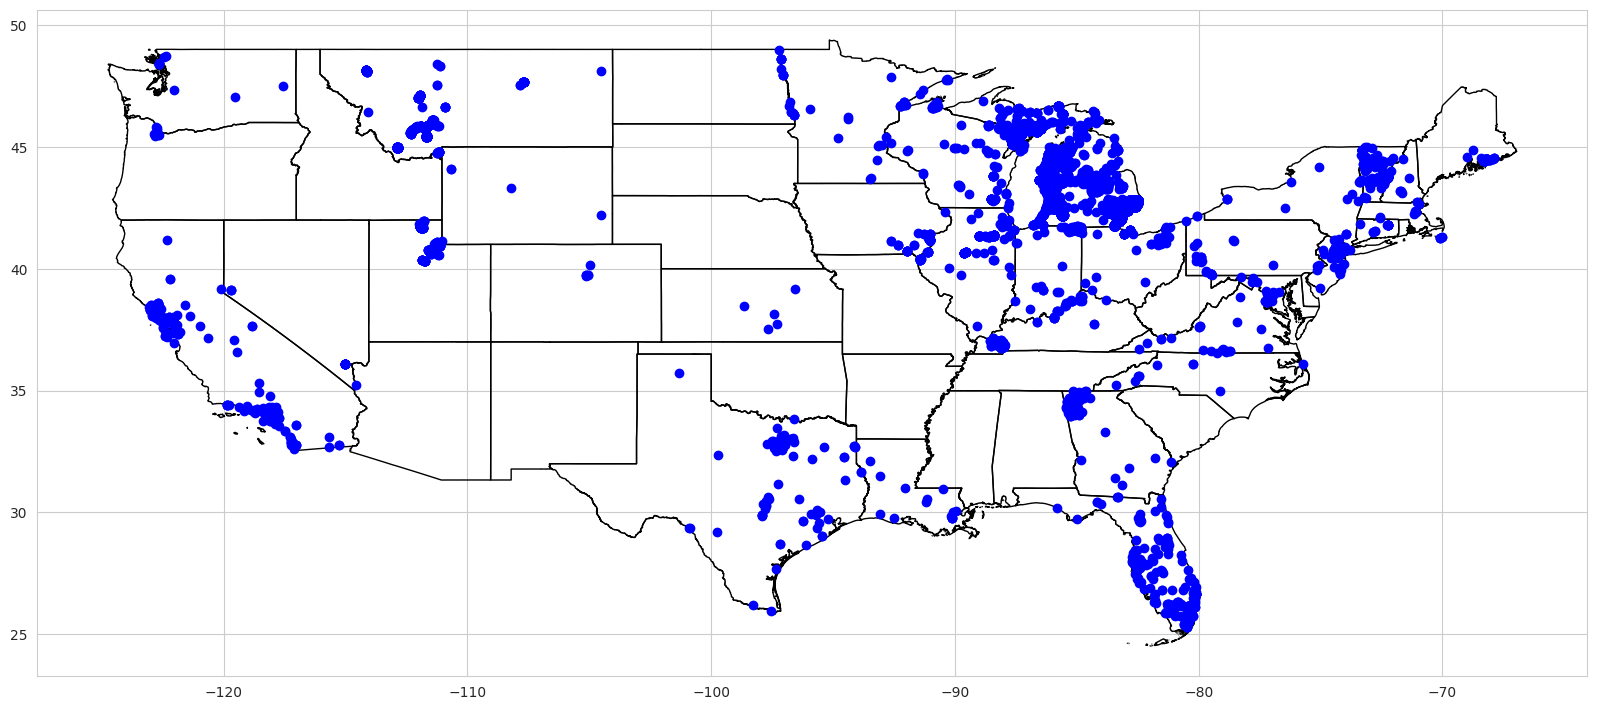

In [ ]:
#..How to fix it?
#USA have many unincorporated territories in their control (https://en.wikipedia.org/wiki/Unincorporated_territories_of_the_United_States)
#Remove states with many islands. Some states have many islands in their control (https://en.wikipedia.org/wiki/List_of_islands_of_the_United_States_by_area)
spatg=spat #backup
spat=spat[-spat.name.isin(['Hawaii','Alaska'])] #sum(spec.state=='alaska') Also, no elements
#Now plot the map
ax = spat.plot(figsize=(20,20), color='none', edgecolor='black', zorder=1) #boundary
points.plot(color='blue', ax=ax) #Elements to add

In [ ]:
#Now add a temporal variation too
spec_t1=spec[spec.gyear=='1600-1900']
spec_t2=spec[spec.gyear=='1901-1930']
spec_t3=spec[spec.gyear=='1931-1950']
spec_t4=spec[spec.gyear=='1951-1970']
spec_t5=spec[spec.gyear=='1971-1990']
spec_t6=spec[spec.gyear=='1991-2016']
#for i in spec['gyear'].values: lst.append(spec[spec.year==i])
def plot_map(df):
    points = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.decimalLon, df.decimalLat))
    ax = spat.plot(figsize=(20,20), color='none',edgecolor='black', zorder=1) #Same boundary
    points.plot(color='blue', ax=ax) #In same boundary
#plot_map(spec_t1)
#plot_map(spec_t6)
#Maybe this is not interpetable but it can shows how today there are several species compared to before
#I think that the ideal is per year(or per day), not for a large range. I suggest build a dynamic plot


In [ ]:
#Define the observations and features that you want to analyze
#Species #Clearly, is convenient define the plot based on a specific specie
pl_2001=spec[(spec.sciname=='Phalaris arundinacea')&(spec.year==2001)]
salmo_2001=spec[(spec.sciname=='Salmo trutta')&(spec.year==2001)]
#Boundary
spat_s = spat[["name", "geometry"]].set_index("name")

In [ ]:
#Build a map interactive
#Point spatial process
m_point = folium.Map(location=[41,-82], tiles='cartodbpositron', zoom_start=4.2) #Define the map

for i in range(0,len(pl_2001)):  #Add points
    folium.Circle(
      location=[pl_2001.iloc[i]['decimalLat'], pl_2001.iloc[i]['decimalLon']],
      radius=pl_2001.iloc[i]['huc12skm'],  #I consider the area of HUC12. See the bubble
      color='green',
      fill=True,
      fill_color='green').add_to(m_point)

for i in range(0,len(salmo_2001)): #Also, is possible add other species
    folium.Circle(
      location=[salmo_2001.iloc[i]['decimalLat'], salmo_2001.iloc[i]['decimalLon']],
      radius=salmo_2001.iloc[i]['huc12skm'],
      color='blue',
      fill=True,
      fill_color='blue').add_to(m_point)

m_point

In [ ]:
m_heatmap = folium.Map(location=[41,-82], tiles='cartodbpositron', zoom_start=4) #Again, define the map
HeatMap(data=salmo_2001[['decimalLat', 'decimalLon']], radius=10).add_to(m_heatmap) #Also, it's possible define a heatmap
#HeatMap(data=pl_2001[['decimalLat', 'decimalLon']], radius=10).add_to(m_heatmap)
m_heatmap

In [ ]:
#For the discrete case is neccesary to define the number of events per region
plot_dict = salmo_2001.state.value_counts()
s=pd.DataFrame(plot_dict).reset_index()
s.columns=['name','count']
#Join tables
dat=pd.merge(s,spat,on='name',how='inner')
dat=dat.fillna(0)

In [ ]:
m_choropleth = folium.Map(location=[41,-82], tiles='cartodbpositron', zoom_start=4) #map
Choropleth(geo_data=spat_s.__geo_interface__, #In generally, add layers (or caractheristics)
           data=plot_dict,
           key_on="feature.id",
           fill_color='YlGn',
           legend_name='Major presence of Phalaris arundinacea (Jan-Dec 2001)'
          ).add_to(m_choropleth)
m_choropleth

In [ ]:
#Build a dynamic map
spec_e=spec[(spec.year>1900)&(spec.year<1971)]  #Only until 1970. Sorry, I couldn't optimize this part of the code, it took a long time if it was considered more years. If you consider more dates, remember the high rise betwwn 2005 and 2015
#spec_e=spec_e[spec_e.sciname=='Salmo trutta'] #You can choose an specific specie
plot_dict = spec_e[['state','year']].value_counts() #Transform to a discrete case. See the spatiotemporal index
s=pd.DataFrame(plot_dict).reset_index()
s.columns=['name','year','events'] #Same name of columns

spatg = spatg[["iso_code","name", "geometry"]]
spatg.iso_code=spatg.iso_code.apply(lambda x: str(x)[3:]) #In this case, the spatial code should be different

#Join tables
dat=pd.merge(s,spatg,on='name',how='inner')
dat=dat.sort_values(by='year', ascending=True).reset_index()
del dat['index']
dat

name  year  events iso_code  \
0      Illinois  1901       3       IL   
1         Maine  1901       3       ME   
2        Oregon  1901       2       OR   
3      Michigan  1901       4       MI   
4       Vermont  1901       1       VT   
...         ...   ...     ...      ...   
1719   Virginia  1970       5       VA   
1720   Michigan  1970      20       MI   
1721      Idaho  1970      11       ID   
1722  Minnesota  1970       1       MN   
1723   Missouri  1970      12       MO   

                                               geometry  
0     POLYGON ((-91.51297 40.18106, -91.51107 40.188...  
1     MULTIPOLYGON (((-67.35580 44.64226, -67.35437 ...  
2     MULTIPOLYGON (((-123.59892 46.25145, -123.5984...  
3     MULTIPOLYGON (((-83.19159 42.03537, -83.18993 ...  
4     POLYGON ((-73.43774 44.04501, -73.43199 44.063...  
...                                                 ...  
1719  MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...  
1720  MULTIPOLYGON (((-83.19159 42.03537, -83.18993 ...  
1721  POLYGON ((-117.24268 44.39655, -117.23484 44.3...  
1722  MULTIPOLYGON (((-89.59206 47.96668, -89.59147 ...  
1723  POLYGON ((-95.77355 40.57820, -95.76853 40.583...  

[1724 rows x 5 columns]

In [ ]:
df=pd.merge(spatg[['name','iso_code']],dat.year,how='cross') #I added zero values for the map. Maybe there's an alternative way
datf=pd.merge(dat,df,on=['name','year'],how='outer')
datf['events']=datf['events'].fillna(0) #Region without species should be 0

In [ ]:
!pip install plotly

In [ ]:
import plotly.express as px
fig = px.choropleth(datf,
                     locations='iso_code_y', locationmode='USA-states',     # identify country code column
                     color="events",                     # identify representing column
                     animation_frame="year",        # identify date column
                     scope='usa',                #shows only this country
                     color_continuous_scale= 'Ylgn',
                     range_color=[0,datf.events.max()])
fig.write_html("historic-invasion.html")
fig.show() #It can looks better. Maybe it's better to use a point process